**Importing the necessary libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Loading Data**

In [4]:
data = pd.read_csv(r'C:\Users\rehma\Pictures\Daily_tasks\Rahman-Analytics-Lab\project_01\data.csv', encoding="ISO-8859-1") 
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
data.shape

(541909, 8)

### Data processing

**Missing data**

In [8]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID 135080 of missing rows (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers,Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis. By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset

In [9]:
data = data[data['CustomerID'].isna()==False]

In [10]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Duplicated Rows**

In [11]:
data.duplicated().sum()

5225

In [13]:
data.drop_duplicates(inplace= True)

**Converting dtypes**

In [14]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

let's convert 'InvoiceDate' to a datetime data type and 'CustomerID' to an integer data type.

In [15]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [16]:
data['CustomerID'] = data['CustomerID'].astype(int , errors = 'ignore')

**Treating With Cancelled Transactions**

we will drop it now and and analysis it later

In [17]:
data = data[data['InvoiceNo'].apply(lambda x : x[0]) != 'C']

## Customer Lifetime Value

There are lots of approaches available for calculating CLTV. Everyone has his own view on it that suitable for his bussines

__CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.__

In [18]:
#Calulate total purchase
data['total purchase'] = data['UnitPrice'] * data['Quantity']

In [20]:
data_group = data.groupby('CustomerID' , as_index=False).agg({
    'total purchase':'sum' , 'InvoiceNo':'count' ,'Country':'min' ,'InvoiceDate':lambda date:(max(date) - min(date)).days}).rename(
      columns = {'InvoiceNo' : 'num_transactions' , 'InvoiceDate':'days'})

__1. Calculate Average Order Value__

In [21]:
data_group['avg_order_value'] = data_group['total purchase']/data_group['num_transactions']

In [22]:
data_group.head()

,CustomerID,total purchase,num_transactions,Country,days,avg_order_value
0,12346,77183.60,1,United Kingdom,0,77183.600000
1,12347,4310.00,182,Iceland,365,23.681319
2,12348,1797.24,31,Finland,282,57.975484
3,12349,1757.55,73,Italy,0,24.076027
4,12350,334.40,17,Norway,0,19.670588


__2. Calculate Purchase Frequency__

In [23]:
purchase_frequency=sum(data_group['num_transactions'])/data_group.shape[0]

__3. Calculate Repeat Rate and Churn Rate__

In [24]:
repeat_rate = len(data_group[data_group['num_transactions'] >= 2]) / len(data_group)
round(repeat_rate*100.0 , 2)

98.34

the percentage of repeat_rate is :98.34 %

__Churn Rate__

In [25]:
#Churn Rate
churn_rate=1-repeat_rate
round(churn_rate*100.0 , 2)

1.66

the percentage of Churn rate is :1.66 %

**4. Calculate Profit Margin**

It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 10% profit on the total sale.

In [26]:
data_group['profit_margin']=data_group['total purchase']*0.1

**5. Calcualte Customer Lifetime Value**

churn_rate

In [27]:
data_group['CLV']=(data_group['avg_order_value']*purchase_frequency)
data_group['CLV'] = data_group['CLV']/churn_rate
data_group['CLV'] = data_group['CLV'].apply(lambda x: '{:.2f}'.format(x))

data_group.head()

# Customer Segmentation

## based on their total purchase value

In [28]:
data_group_v1 = data_group
data_group_v1['Segmant Purchase'] = pd.cut(data_group['total purchase'] , bins = [0,1500,3500,float('inf')] , labels = ['Low purchase' , 'Medium purchase' ,'High purchase'])

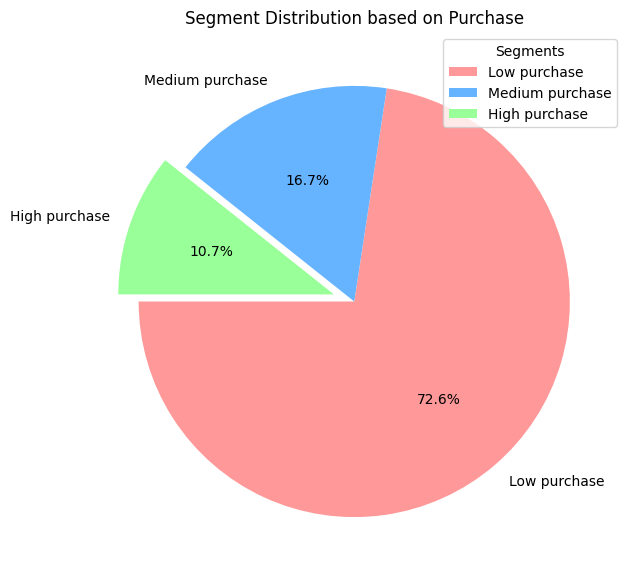

In [29]:
v1 = data_group_v1['Segmant Purchase'].value_counts()

colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = [0,0,0.1]
plt.figure(figsize=(8, 7))
plt.pie(v1, labels=v1.index, colors=colors, autopct='%1.1f%%', startangle=180,explode = explode)
plt.title('Segment Distribution based on Purchase')
plt.legend(v1.index, title='Segments', loc='upper right')
plt.show()

## Cusotmers With High Transactions

In [30]:
# top_10_Custopers
x = data_group[['CustomerID','num_transactions']].sort_values(by = 'num_transactions' ,ascending = [False]).head(10)

Text(0.5, 1.0, 'top_10_Customers')

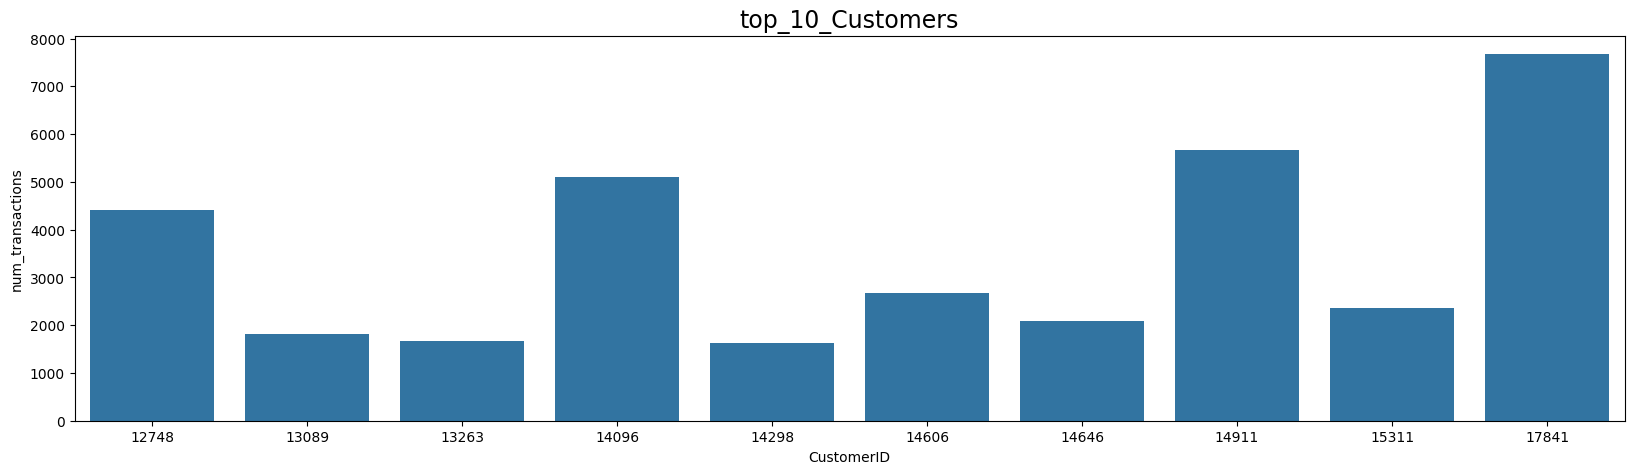

In [31]:
plt.figure(figsize=(20,5))
sns.barplot(data =x , x = 'CustomerID'	,y ='num_transactions')
plt.title("top_10_Customers" , fontsize = 17)

# Geographic Analysis:

## TOP 10 Countries In Revenue of Purchase

In [32]:
data_group_v2 = data_group.groupby('Country' , as_index = False).agg({'total purchase' : 'sum' , 'num_transactions':'sum'})

In [33]:
data_group_v2 = data_group_v2.sort_values(by = 'total purchase' , ascending=False).head(10)

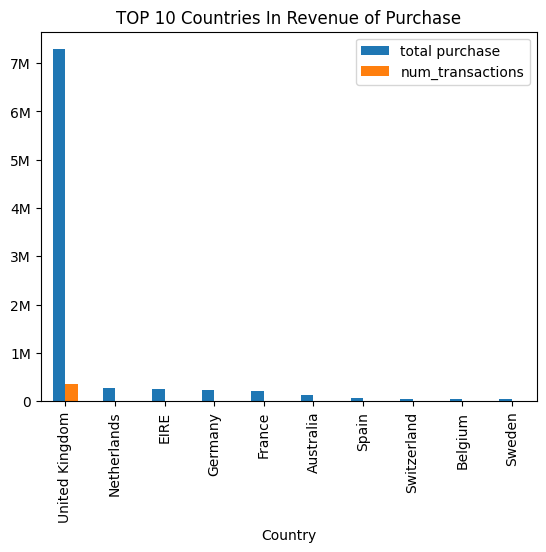

In [34]:
from matplotlib.ticker import FuncFormatter
data_group_v2.plot(kind = 'bar' , x = 'Country')
def format_y_ticks(value, _):
    if value >= 1e6:
        return f'{int(value/1e6)}M'
    else:
        return int(value)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.title('TOP 10 Countries In Revenue of Purchase')
plt.show()

### In which Country do we have more customers?

In [35]:
country = data_group['Country'].value_counts().reset_index(drop = False).head(10)
country

,Country,count
0,United Kingdom,3921
1,Germany,94
2,France,87
3,Spain,28
4,Belgium,24
5,Portugal,19
6,Switzerland,19
7,Italy,14
8,Finland,12
9,Austria,11


### Countries That has high cancellation of orders

In [36]:
data_Cancel = pd.read_csv(r'C:\Users\rehma\Pictures\Daily_tasks\Rahman-Analytics-Lab\project_01\data.csv' , encoding="ISO-8859-1")
data_Cancel = data_Cancel[data_Cancel['InvoiceNo'].apply(lambda x : x[0]) == 'C']
data_Cancel['InvoiceDate'] = pd.to_datetime(data_Cancel['InvoiceDate'])

In [37]:
data_Cancel_vals = data_Cancel['Country'].value_counts().nlargest(5)

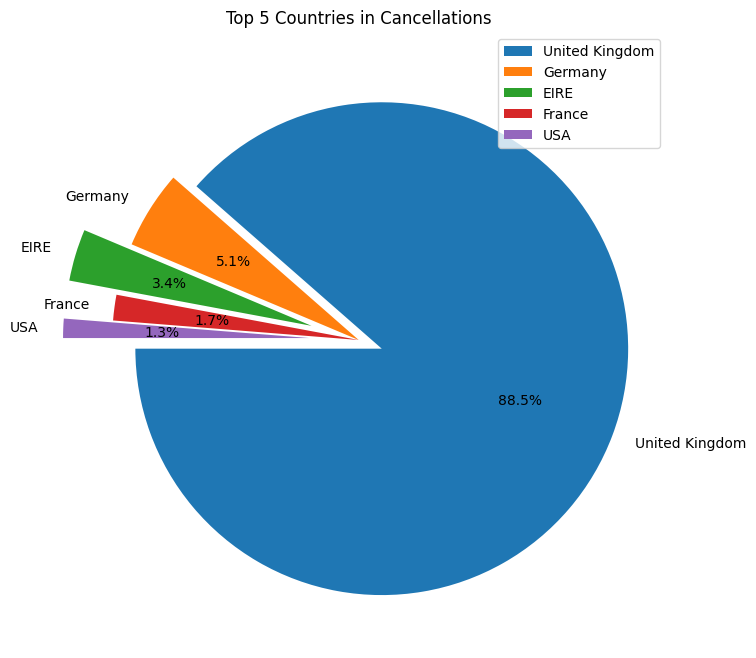

In [38]:
explode =[0.1,0,0.2,0,0.2]
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightpink']

plt.figure(figsize=(8, 8))
plt.pie(data_Cancel_vals, labels=data_Cancel_vals.index, autopct='%1.1f%%', startangle=180 , explode = explode)

plt.title('Top 5 Countries in Cancellations')
plt.legend(loc='upper right', labels=data_Cancel_vals.index)
plt.show()

### Countries with low cancellation of orders

In [39]:
data_Cancel_vals_2 = data_Cancel['Country'].value_counts().nsmallest(5)

In [40]:
data_Cancel_vals_2

Country
Saudi Arabia          1
Bahrain               1
European Community    1
Greece                1
Israel                2
Name: count, dtype: int64

# Time Series Analysis:

### any patterns or trends in Count of Orders?

In [41]:
data['InvoiceDate_d'] = data['InvoiceDate'].dt.date

In [42]:
PurchaseDate_data = data.groupby('InvoiceDate_d', as_index = False).agg({'InvoiceNo':'count' ,'total purchase':'sum' })

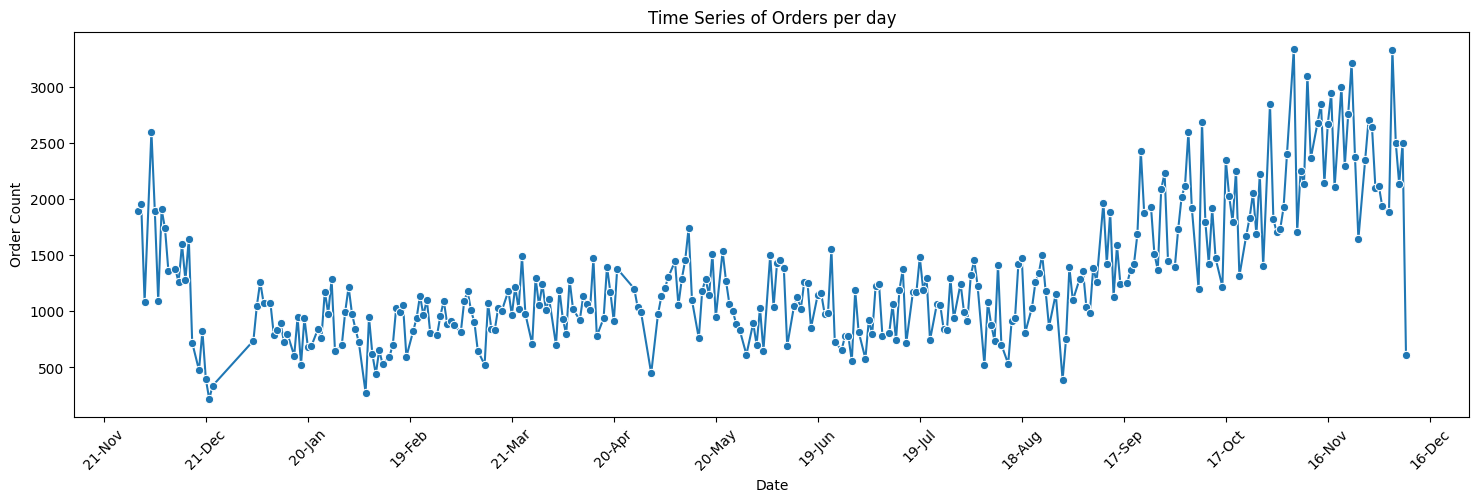

In [43]:
plt.figure(figsize=(18, 5))
sns.lineplot(data = PurchaseDate_data , x='InvoiceDate_d', y='InvoiceNo' , marker = 'o')

plt.title('Time Series of Orders per day')
plt.xlabel('Date')
plt.ylabel('Order Count')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter("%d-%b")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation=45)
plt.show()

## Month VS total purchase

In [44]:
data['month'] = pd.to_datetime(data['InvoiceDate']).dt.month
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
data['month'] = data['month'].map(month_dict)
data['month'] = pd.Categorical(data['month'], categories=month_dict.values())

In [45]:
month_data = data.groupby('month', as_index=False, observed=False)['total purchase'].sum()
month_data

,month,total purchase
0,January,568101.310
1,February,446084.920
2,March,594081.760
3,April,468374.331
4,May,677355.150
5,June,660046.050
6,July,598962.901
7,August,644051.040
8,September,950690.202
9,October,1035642.450


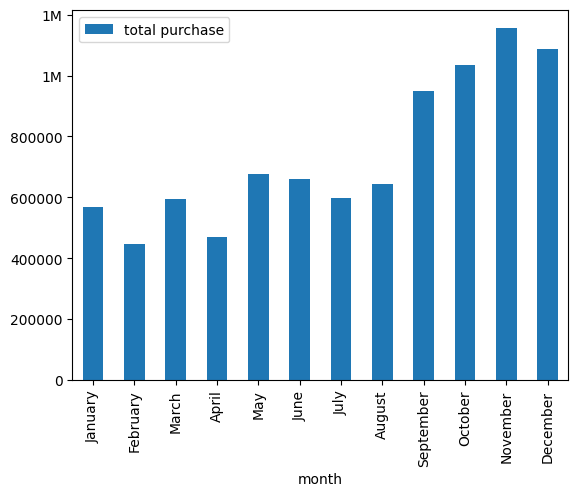

In [46]:
month_data.plot(kind = 'bar' , x = 'month')
from matplotlib.ticker import FuncFormatter

def format_y_ticks(value, _):
    if value >= 1e6:
        return f'{int(value/1e6)}M'
    else:
        return int(value)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.show()

### Month with High cancellation of orders

In [47]:
data_Cancel['month'] = data_Cancel['InvoiceDate'].dt.month_name()

In [48]:
data_month_cancel = data_Cancel.groupby('month' , as_index= False)['InvoiceNo'].count()

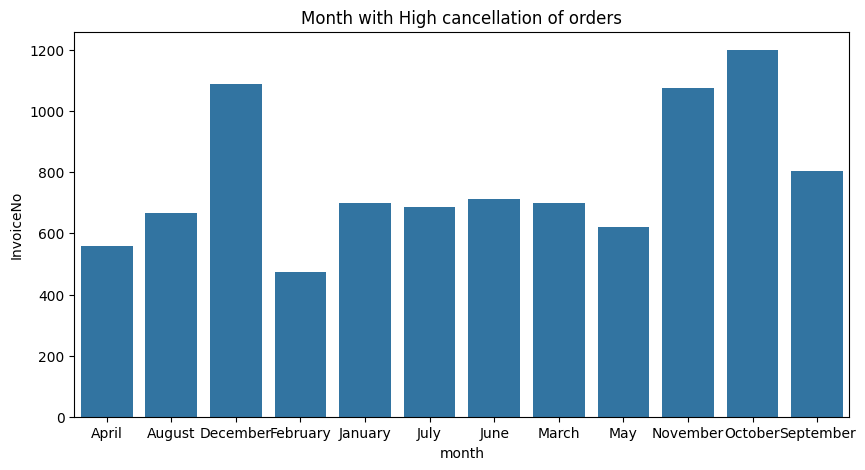

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(data = data_month_cancel , x = 'month' , y ='InvoiceNo' )
plt.title("Month with High cancellation of orders")
plt.show()

## Stock Analysis

### Top 10 Stocks With High Orders

<Axes: xlabel='StockCode'>

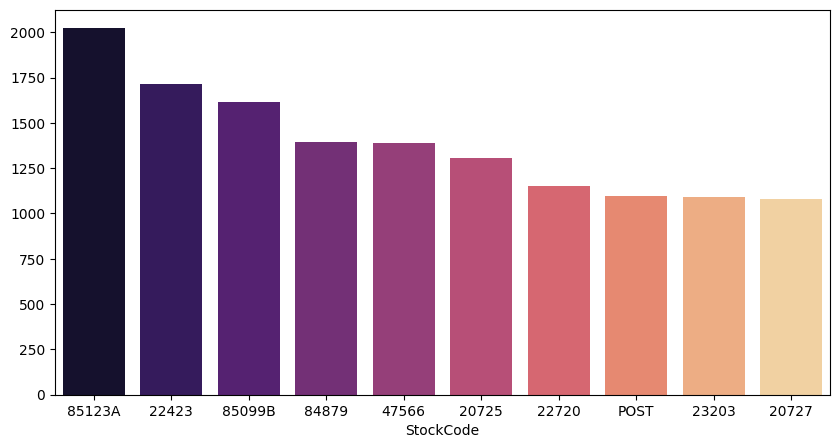

In [50]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=stockcode_counts.index, y=stockcode_counts.values, palette='magma', hue=stockcode_counts.index)

## Descriptions Analysis

In [51]:
# How many unique descriptions do we have?
data['Description'].nunique()

3877

#### which are most common descriptions?

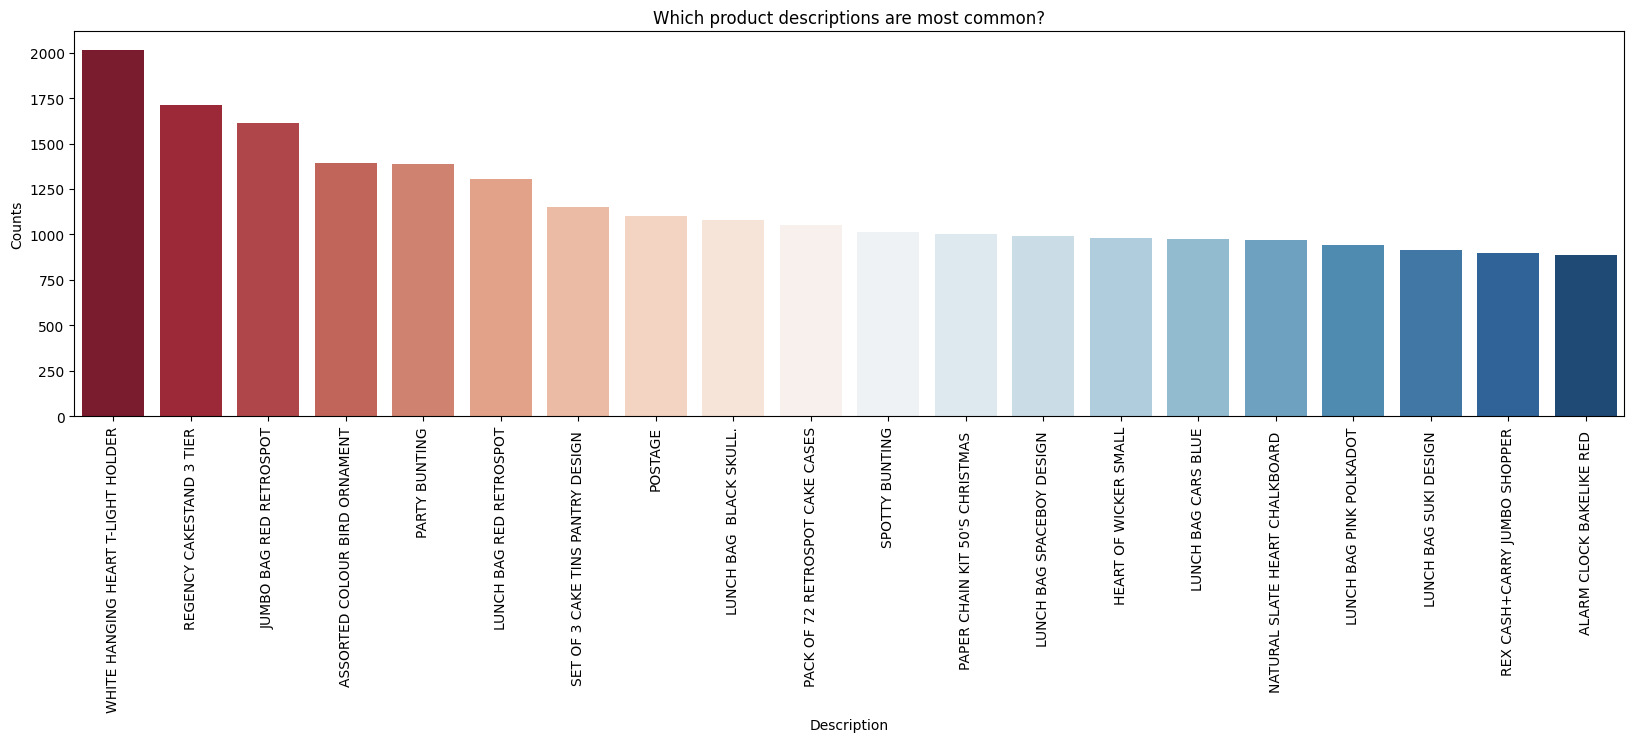

In [52]:
description_counts = data.Description.value_counts().sort_values(ascending=False).head(20)

plt.figure(figsize=(20, 5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="RdBu", hue=description_counts.index)
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?")
plt.xticks(rotation=90)
plt.show()

#### Which product has achieved the highest sales?

In [53]:
data['total'] = data['UnitPrice']*data['Quantity']

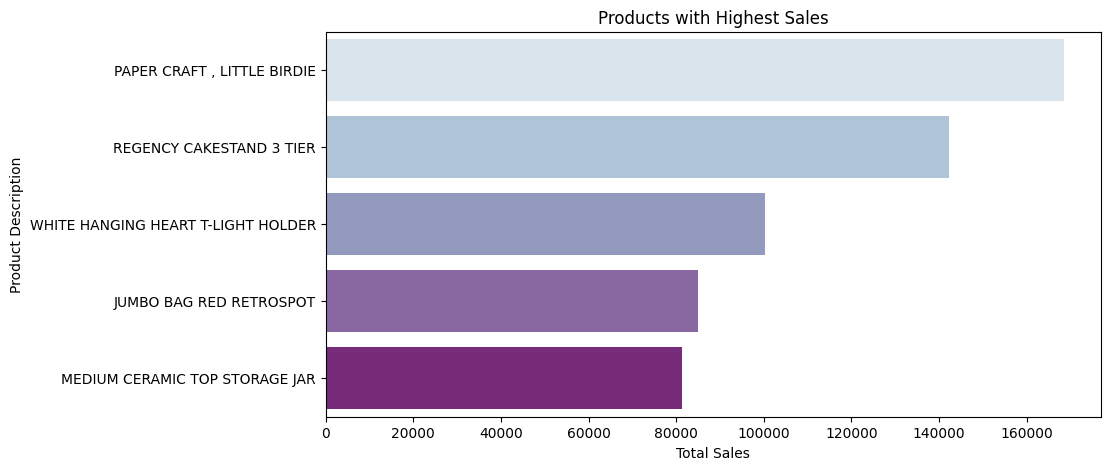

In [54]:
product_sales = data.groupby('Description').agg({'total': 'sum'}).sort_values(by='total', ascending=False).reset_index(drop=False).head(5)

plt.figure(figsize=(10, 5))
ad = sns.barplot(y='Description', x='total', data=product_sales, palette='BuPu', hue='Description')

plt.title('Products with Highest Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Description')
plt.show()

**Feature Engineering**

From existing data, we can create several predictive features:

In [55]:
# Create additional features from existing data
data_group['avg_purchase_value'] = data_group['total purchase'] / data_group['num_transactions']
data_group['purchase_frequency'] = data_group['num_transactions'] / data_group['days']
data_group['recency'] = data_group['days']  # Days since first purchase
data_group['country_encoded'] = data_group['Country'].astype('category').cat.codes

# Convert CLV from string to numeric (you had formatted it as string earlier)
data_group['CLV'] = data_group['CLV'].astype(float)

**Select Relevant Features**

Choose features that might predict CLV:

In [56]:
features = ['num_transactions', 'days', 'avg_order_value', 'total purchase', 
            'avg_purchase_value', 'purchase_frequency', 'recency', 'country_encoded']
target = 'CLV'

**Split Data into Training and Test Sets**

In [57]:
from sklearn.model_selection import train_test_split

X = data_group[features]
y = data_group[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build and Evaluate Regression Models**

Linear Regression (Baseline)

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Clean the data
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

# Evaluate
print("Linear Regression Performance:")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

Linear Regression Performance:
MSE: 8.07699291339219e-06
R²: 0.9999999999999999


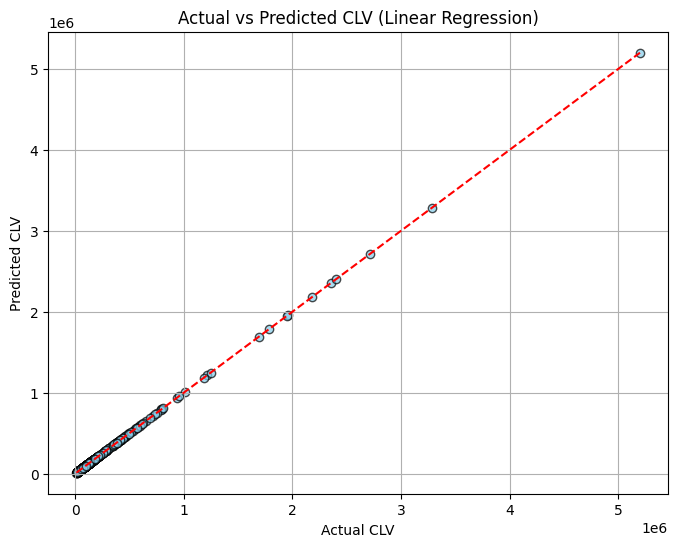

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='skyblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted CLV (Linear Regression)')
plt.grid(True)
plt.show()